- 현업 필터링의 주요 목표는 사용자 - 아이템 평점 매트릭스와 같은 축적된 사용자 행동 데이터를 기반으로 사용자가 아직 평가하지 않은 아이템을 예측 평가하는 것 
- 현업 필터링 기반은 '최근접 이웃 방식'(Memory 협업 필터링), ' 잠재요인방식'으로 나눈다
- 최근접 이웃 협업 필터링은 다시 사용자기반, 아이템 기반으로 나누어집니다 
- 사용자 기반 : 당신과 비슷한 고객들이 다음 상품도 구매했습니다. 즉, 특정 사용자와 타 사용자간의 유사도를 측정한 뒤 가장 유사도가 높은 Top N 사용자를 추출해 그글이 선호하는 아이템을 추천하는것. 
- 아이템 기반 : 이 상품을 선택한 다른 고객들은 다음 상품도 구매했습니다. 아이템이 가지는 속성과는 상관 없이 사용자들이 그 아이템을 좋아하는지/싫어하는지의 평가 척도가 유사한 아이템을 추천하는 기준이 되는 알고리즘.
- 최근에는 아이템 기반 최근접 이웃 협업 필털링을 많이 사용

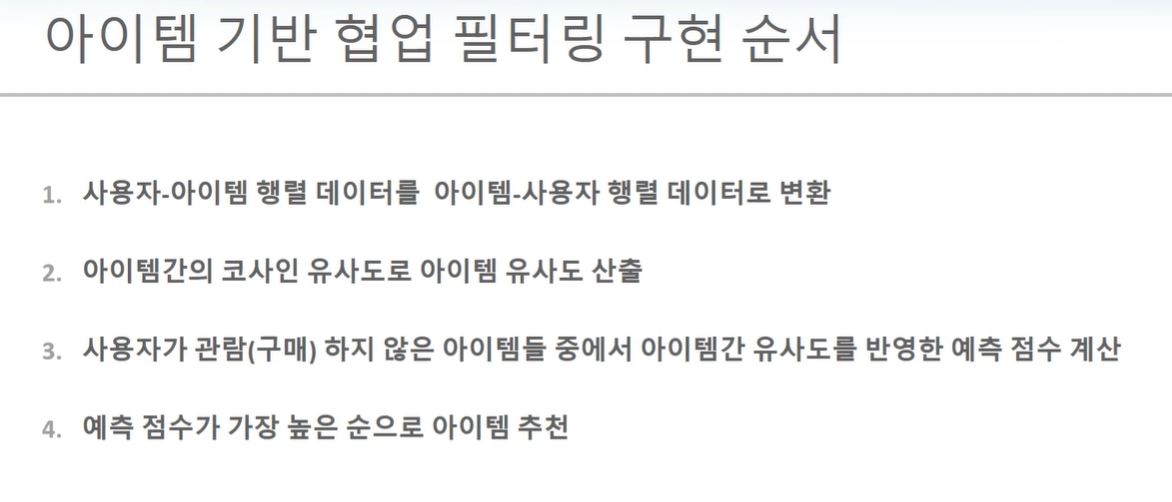

In [2]:
from IPython.display import Image
Image('./Item기반_협업필터링2.JPG')

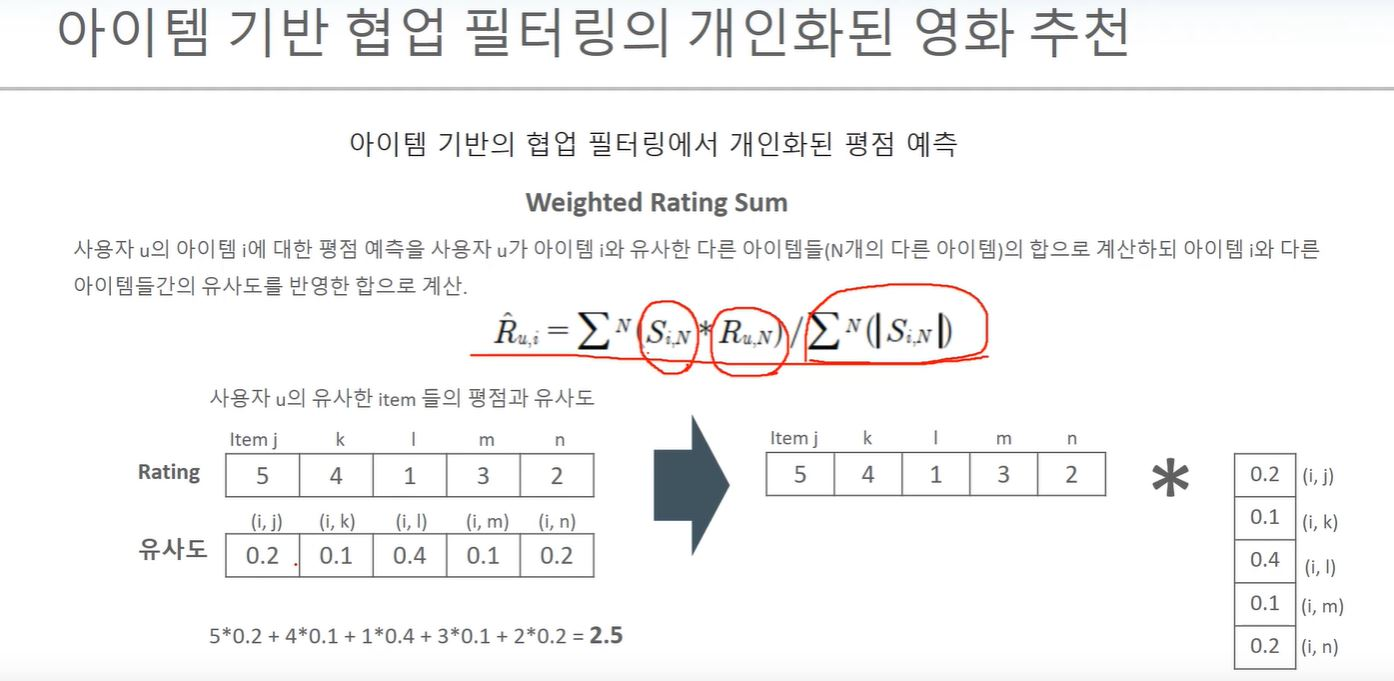

In [3]:
Image('./Item기반_협업필터링_weighted.JPG')

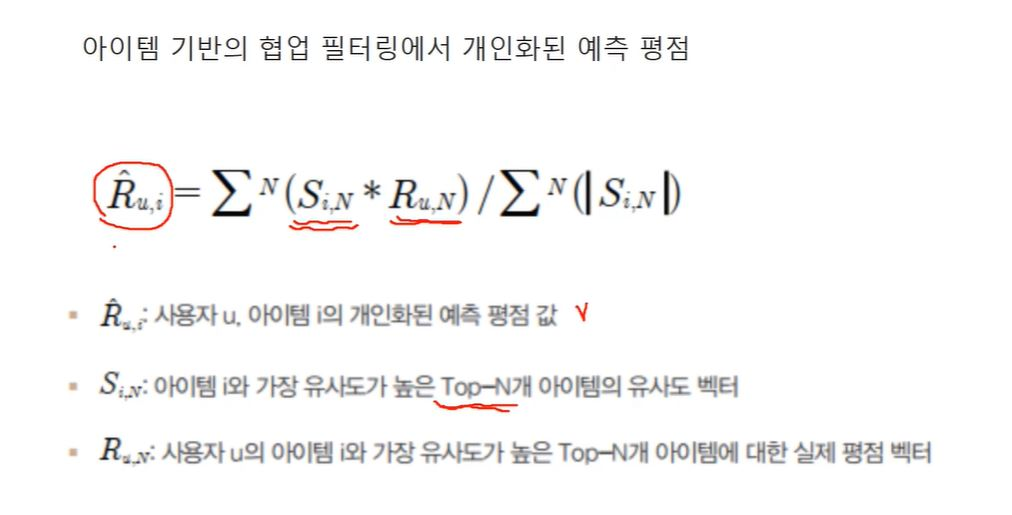

In [4]:
Image('./Item기반_협업필터링_weighted2.JPG')

**데이터 로드**

In [5]:
import pandas as pd
import numpy as np

movies = pd.read_csv('./ml-latest-small/movies.csv')
ratings = pd.read_csv('./ml-latest-small/ratings.csv')
print(movies.shape)
print(ratings.shape)

(9742, 3)
(100836, 4)


In [6]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


**로우레벨 사용자 평점 데이터를 사용자-아이템 평점 행렬로 변환**

In [8]:
ratings = ratings[['userId', 'movieId', 'rating']]

### pivot table 이용 
ratings_matrix = ratings.pivot_table('rating', index='userId', columns='movieId')
ratings_matrix.head(3)

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# title 컬럼을 얻기 이해 movies 와 조인 수행
rating_movies = pd.merge(ratings, movies, on='movieId')

# columns='title' 로 title 컬럼으로 pivot 수행. 
ratings_matrix = rating_movies.pivot_table('rating', index='userId', columns='title')

# NaN 값을 모두 0 으로 변환
ratings_matrix = ratings_matrix.fillna(0)
ratings_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 영화와 영화들 간 유사도 산출

In [10]:
ratings_matrix_T = ratings_matrix.transpose()
ratings_matrix_T.head(3)

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
'Hellboy': The Seeds of Creation (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Round Midnight (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
ratings_matrix_T.shape

(9719, 610)

In [12]:
### 유사도 산출 

from sklearn.metrics.pairwise import cosine_similarity

item_sim = cosine_similarity(ratings_matrix_T, ratings_matrix_T)

# cosine_similarity() 로 반환된 넘파이 행렬을 영화명을 매핑하여 DataFrame으로 변환
item_sim_df = pd.DataFrame(data=item_sim, index=ratings_matrix.columns,
                          columns=ratings_matrix.columns)
print(item_sim_df.shape)
item_sim_df.head(3)

(9719, 9719)


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),1.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.141653,0.0,...,0.0,0.342055,0.543305,0.707107,0.0,0.0,0.139431,0.327327,0.0,0.0
'Hellboy': The Seeds of Creation (2004),0.0,1.000000,0.707107,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
'Round Midnight (1986),0.0,0.707107,1.000000,0.0,0.0,0.0,0.176777,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0


In [13]:
item_sim_df["Godfather, The (1972)"].sort_values(ascending=False)[:6]

title
Godfather, The (1972)                        1.000000
Godfather: Part II, The (1974)               0.821773
Goodfellas (1990)                            0.664841
One Flew Over the Cuckoo's Nest (1975)       0.620536
Star Wars: Episode IV - A New Hope (1977)    0.595317
Fargo (1996)                                 0.588614
Name: Godfather, The (1972), dtype: float64

In [16]:
item_sim_df["Godfather, The (1972)"].sort_values(ascending=False)[1:7]

title
Godfather: Part II, The (1974)                           0.821773
Goodfellas (1990)                                        0.664841
One Flew Over the Cuckoo's Nest (1975)                   0.620536
Star Wars: Episode IV - A New Hope (1977)                0.595317
Fargo (1996)                                             0.588614
Star Wars: Episode V - The Empire Strikes Back (1980)    0.586030
Name: Godfather, The (1972), dtype: float64

In [14]:
### 자신의 영화 제외
item_sim_df["Inception (2010)"].sort_values(ascending=False)[1:6]

title
Dark Knight, The (2008)          0.727263
Inglourious Basterds (2009)      0.646103
Shutter Island (2010)            0.617736
Dark Knight Rises, The (2012)    0.617504
Fight Club (1999)                0.615417
Name: Inception (2010), dtype: float64

### 아이템 기반 인접 이웃 협업 필터링으로 개인화된 영화 추천

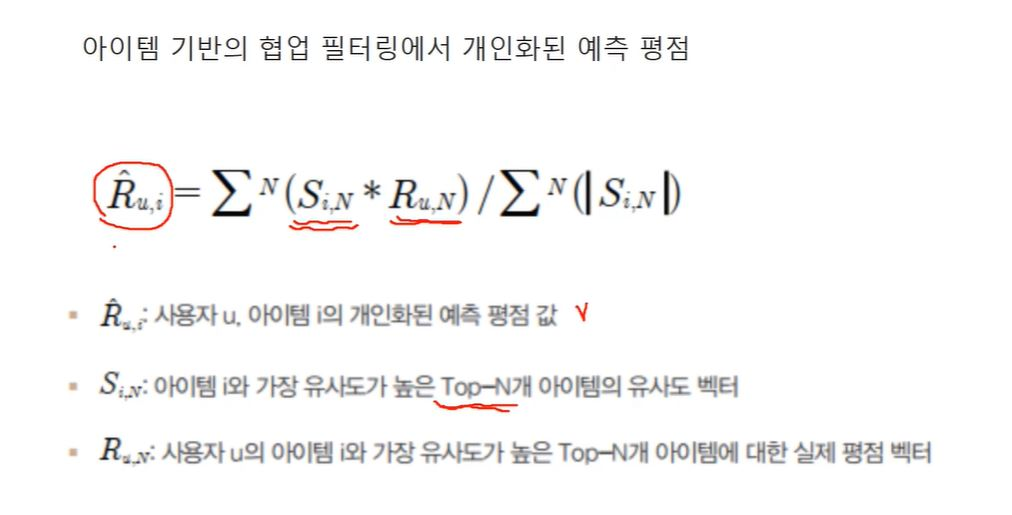

In [17]:
Image('./Item기반_협업필터링_weighted2.JPG')

In [18]:
### 단순히 아이템의 유사도뿐만 아니라 개인의 취향을 반영한 영화 추천 
### 개인화된 예측 평점의 산식 

def predict_rating(ratings_arr, item_sim_arr ):
    ratings_pred = ratings_arr.dot(item_sim_arr)/ np.array([np.abs(item_sim_arr).sum(axis=1)])
    return ratings_pred

In [19]:
### 사용자기반평점
ratings_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
### input 사용자 평점, 영화간 유사도 Data
### values를 통한 ndarray 형태로 변경 
ratings_pred = predict_rating(ratings_matrix.values , item_sim_df.values)

ratings_pred_matrix = pd.DataFrame(data=ratings_pred, index= ratings_matrix.index,
                                   columns = ratings_matrix.columns)
print(ratings_pred_matrix.shape)
ratings_pred_matrix.head(3)

(610, 9719)


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.070345,0.577855,0.321696,0.227055,0.206958,0.194615,0.249883,0.102542,0.157084,0.178197,...,0.113608,0.181738,0.133962,0.128574,0.006179,0.212070,0.192921,0.136024,0.292955,0.720347
2,0.018260,0.042744,0.018861,0.000000,0.000000,0.035995,0.013413,0.002314,0.032213,0.014863,...,0.015640,0.020855,0.020119,0.015745,0.049983,0.014876,0.021616,0.024528,0.017563,0.000000
3,0.011884,0.030279,0.064437,0.003762,0.003749,0.002722,0.014625,0.002085,0.005666,0.006272,...,0.006923,0.011665,0.011800,0.012225,0.000000,0.008194,0.007017,0.009229,0.010420,0.084501


**가중치 평점 부여뒤에 예측 성능 평가 MSE를 구함**

In [22]:
### 기존 평점과 예측 평점의 차이 
from sklearn.metrics import mean_squared_error

# 사용자가 평점을 부여한 영화에 대해서만 예측 성능 평가 MSE 를 구함. 
# flatten() 다차원 배열을 1차원 배열로 변경 
def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

print('아이템 기반 모든 인접 이웃 MSE: ', get_mse(ratings_pred, ratings_matrix.values ))
### MSE가 높아 보일 수는 있으나 스케일이 다르기때문에, 그렇고 중요한 것은 MSE를 감소시켜 나갸야 한다

아이템 기반 모든 인접 이웃 MSE:  9.895354759094706


**top-n 유사도를 가진 데이터들에 대해서만 예측 평점 계산**

In [23]:
### 전체가 아닌, 유사한 N인자만 가지고 예측

def predict_rating_topsim(ratings_arr, item_sim_arr, n=20):
    # 사용자-아이템 평점 행렬 크기만큼 0으로 채운 예측 행렬 초기화
    pred = np.zeros(ratings_arr.shape)

    # 사용자-아이템 평점 행렬의 열 크기만큼 Loop 수행. 
    for col in range(ratings_arr.shape[1]):
        # 유사도 행렬에서 유사도가 큰 순으로 n개 데이터 행렬의 index 반환
        top_n_items = [np.argsort(item_sim_arr[:, col])[:-n-1:-1]]
        # 개인화된 예측 평점을 계산
        for row in range(ratings_arr.shape[0]):
            pred[row, col] = item_sim_arr[col, :][top_n_items].dot(ratings_arr[row, :][top_n_items].T) 
            pred[row, col] /= np.sum(np.abs(item_sim_arr[col, :][top_n_items]))        
    return pred

**top-n 유사도 기반의 예측 평점 및 MSE 계산**

In [24]:
ratings_pred = predict_rating_topsim(ratings_matrix.values , item_sim_df.values, n=20)
print('아이템 기반 인접 TOP-20 이웃 MSE: ', get_mse(ratings_pred, ratings_matrix.values ))


# 계산된 예측 평점 데이터는 DataFrame으로 재생성
ratings_pred_matrix = pd.DataFrame(data=ratings_pred, index= ratings_matrix.index,
                                   columns = ratings_matrix.columns)


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


아이템 기반 인접 TOP-20 이웃 MSE:  3.69501623729494


In [25]:
user_rating_id = ratings_matrix.loc[9, :]
user_rating_id[ user_rating_id > 0].sort_values(ascending=False)[:10]

title
Adaptation (2002)                                                                 5.0
Austin Powers in Goldmember (2002)                                                5.0
Lord of the Rings: The Fellowship of the Ring, The (2001)                         5.0
Lord of the Rings: The Two Towers, The (2002)                                     5.0
Producers, The (1968)                                                             5.0
Citizen Kane (1941)                                                               5.0
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)    5.0
Back to the Future (1985)                                                         5.0
Glengarry Glen Ross (1992)                                                        4.0
Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)                                     4.0
Name: 9, dtype: float64

**사용자가 관람하지 않은 영화 중에서 아이템 기반의 인접 이웃 협업 필터링으로 영화 추천**

In [26]:
# 사용자가 보지 않은 영화 리스트를 객체로 반환 하는 함수 

def get_unseen_movies(ratings_matrix, userId):
    # userId로 입력받은 사용자의 모든 영화정보 추출하여 Series로 반환함. 
    # 반환된 user_rating 은 영화명(title)을 index로 가지는 Series 객체임. 
    user_rating = ratings_matrix.loc[userId,:]
    
    # user_rating이 0보다 크면 기존에 관람한 영화임. 대상 index를 추출하여 list 객체로 만듬
    already_seen = user_rating[ user_rating > 0].index.tolist()
    
    # 모든 영화명을 list 객체로 만듬. 
    movies_list = ratings_matrix.columns.tolist()
    
    # list comprehension으로 already_seen에 해당하는 movie는 movies_list에서 제외함. 
    unseen_list = [ movie for movie in movies_list if movie not in already_seen]
    
    return unseen_list

In [28]:
def get_unseen_movies_v2(ratings_matrix, userId):
    # userId로 입력받은 사용자의 모든 영화정보 추출하여 Series로 반환함. 
    # 반환된 user_rating 은 영화명(title)을 index로 가지는 Series 객체임. 
    user_rating = ratings_matrix.loc[userId,:]
    
    # user_rating이 0보다 크면 기존에 관람한 영화임. 대상 index를 추출하여 list 객체로 만듬
    unseen_list = user_rating[ user_rating == 0].index.tolist()
    
    return unseen_list

**아이템 기반 유사도로 평점이 부여된 데이터 세트에서 해당 사용자가 관람하지 않은 영화들의 예측 평점이 가장 높은 영화를 추천**

In [29]:
def recomm_movie_by_userid(pred_df, userId, unseen_list, top_n=10):
    # 예측 평점 DataFrame에서 사용자id index와 unseen_list로 들어온 영화명 컬럼을 추출하여
    # 가장 예측 평점이 높은 순으로 정렬함. 
    recomm_movies = pred_df.loc[userId, unseen_list].sort_values(ascending=False)[:top_n]
    return recomm_movies
    
# 사용자가 관람하지 않는 영화명 추출   
unseen_list = get_unseen_movies(ratings_matrix, 9)

# 아이템 기반의 인접 이웃 협업 필터링으로 영화 추천 
recomm_movies = recomm_movie_by_userid(ratings_pred_matrix, 9, unseen_list, top_n=10)

# 평점 데이타를 DataFrame으로 생성. 
recomm_movies = pd.DataFrame(data=recomm_movies.values,index=recomm_movies.index,columns=['pred_score'])
recomm_movies

,pred_score
title,
Shrek (2001),0.866202
Spider-Man (2002),0.857854
"Last Samurai, The (2003)",0.817473
Indiana Jones and the Temple of Doom (1984),0.816626
"Matrix Reloaded, The (2003)",0.800990
Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001),0.765159
Gladiator (2000),0.740956
"Matrix, The (1999)",0.732693
Pirates of the Caribbean: The Curse of the Black Pearl (2003),0.689591


In [31]:
def recomm_movie_by_userid(pred_df, userId, unseen_list, top_n=10):
    # 예측 평점 DataFrame에서 사용자id index와 unseen_list로 들어온 영화명 컬럼을 추출하여
    # 가장 예측 평점이 높은 순으로 정렬함. 
    recomm_movies = pred_df.loc[userId, unseen_list].sort_values(ascending=False)[:top_n]
    return recomm_movies
    
# 사용자가 관람하지 않는 영화명 추출   
unseen_list = get_unseen_movies_v2(ratings_matrix, 9)

# 아이템 기반의 인접 이웃 협업 필터링으로 영화 추천 
recomm_movies = recomm_movie_by_userid(ratings_pred_matrix, 9, unseen_list, top_n=10)

# 평점 데이타를 DataFrame으로 생성. 
recomm_movies = pd.DataFrame(data=recomm_movies.values,index=recomm_movies.index,columns=['pred_score'])
recomm_movies

,pred_score
title,
Shrek (2001),0.866202
Spider-Man (2002),0.857854
"Last Samurai, The (2003)",0.817473
Indiana Jones and the Temple of Doom (1984),0.816626
"Matrix Reloaded, The (2003)",0.800990
Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001),0.765159
Gladiator (2000),0.740956
"Matrix, The (1999)",0.732693
Pirates of the Caribbean: The Curse of the Black Pearl (2003),0.689591
